In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report
from joblib import dump

In [76]:
# Load titanic.csv
titanic_df = pd.read_csv('titanic.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing Data

In [77]:
# drop the least relevant columns from the dataset (based on previous analysis)
titanic_df.drop(columns=['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [79]:
# Calculate the percentage of missing values per column
missing_data_rows = []
total_rows = len(titanic_df)

for num in titanic_df.columns:
    missing_values_count = titanic_df[num].isnull().sum()
    percentage_missing_per_column = round((missing_values_count / total_rows) * 100)
    missing_data_rows.append({'Feature': num,'Missing Values Count': missing_values_count,'Percentage Missing': f"{percentage_missing_per_column}%"})

# convert the list of dictionaries into a dataFrame
missing_output_df = pd.DataFrame(missing_data_rows)
missing_output_df

,Feature,Missing Values Count,Percentage Missing
0,Survived,0,0%
1,Pclass,0,0%
2,Sex,0,0%
3,Age,177,20%
4,SibSp,0,0%
5,Parch,0,0%
6,Fare,0,0%
7,Embarked,2,0%


In [80]:
# impute missing values
missing_values_before = titanic_df.isnull().sum()
print(f"Missing values before imputation:\n {missing_values_before}")

titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)

missing_values_after =  titanic_df.isnull().sum()
print(f"\nMissing values after imputation:\n {missing_values_after}")

Missing values before imputation:
 Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Missing values after imputation:
 Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


/var/folders/jf/9cfc0stn05v519631ltpqjmm0000gn/T/ipykernel_2842/4252706030.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
/var/folders/jf/9cfc0stn05v519631ltpqjmm0000gn/T/ipykernel_2842/4252706030.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [81]:
# Encode categorical features
nominal_features = ['Embarked', 'Sex','Pclass']
onehot_encoder = OneHotEncoder()
df_onehot_encoded = onehot_encoder.fit_transform(titanic_df[nominal_features])
df_onehot_encoded_df = pd.DataFrame(df_onehot_encoded.toarray(), columns=onehot_encoder.get_feature_names_out())

# Drop original nominal columns
titanic_df.drop(columns=nominal_features, axis=1, inplace=True)

titanic_df = pd.concat([titanic_df, df_onehot_encoded_df], axis=1)
titanic_df.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [88]:
# split data into X and y
X = titanic_df.drop(columns=['Survived'], axis=1)
y = titanic_df['Survived']

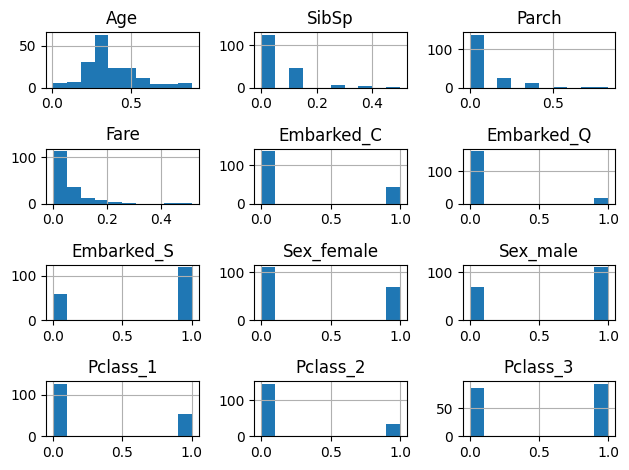

In [89]:
# plot the distributions of features
X_test.hist()
plt.tight_layout()

All features show non-Gaussian distributions. This makes MinMaxScaler() more suitable for scaling the features.

<Axes: >

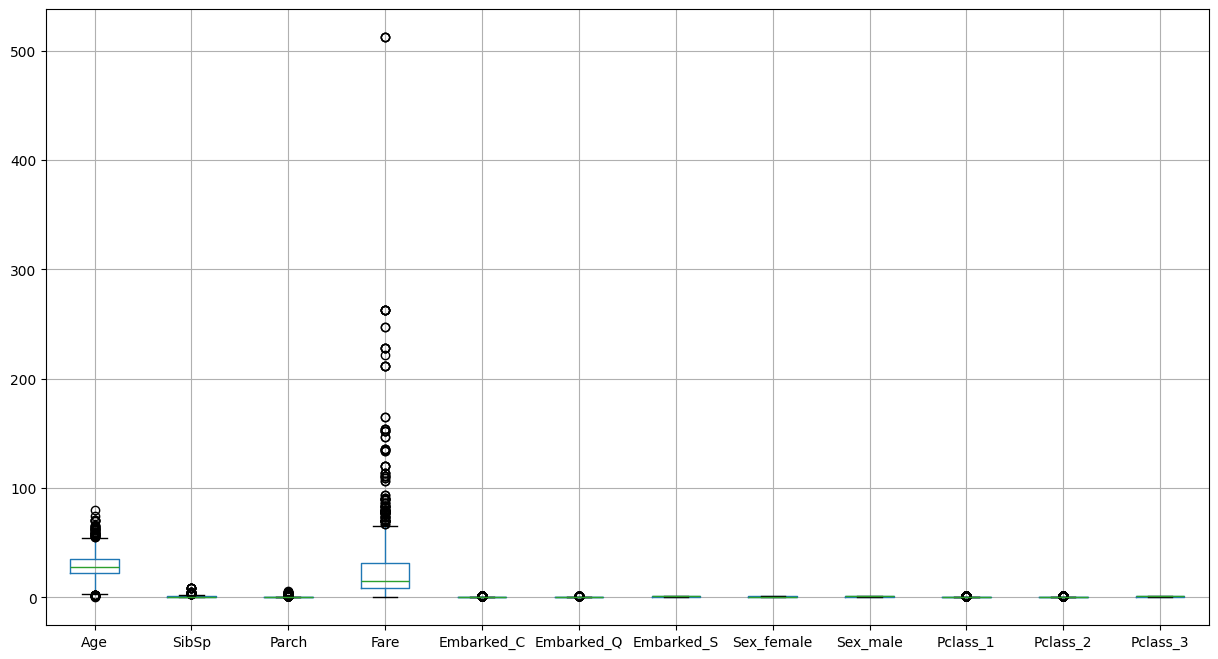

In [90]:
# plot the distributions of features along with their outliers
X.boxplot(figsize=(15, 8))

A few features exhibit outliers that will be addressed in the following cell using the winsorization technique.

In [120]:
# split X and y into train, development and test
random_seed = 42
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full,  test_size=0.2, random_state=random_seed) 

In [92]:
# for non-Gaussian features, use MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

# convert the scaled data back to a DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_dev = pd.DataFrame(X_dev_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

<Axes: >

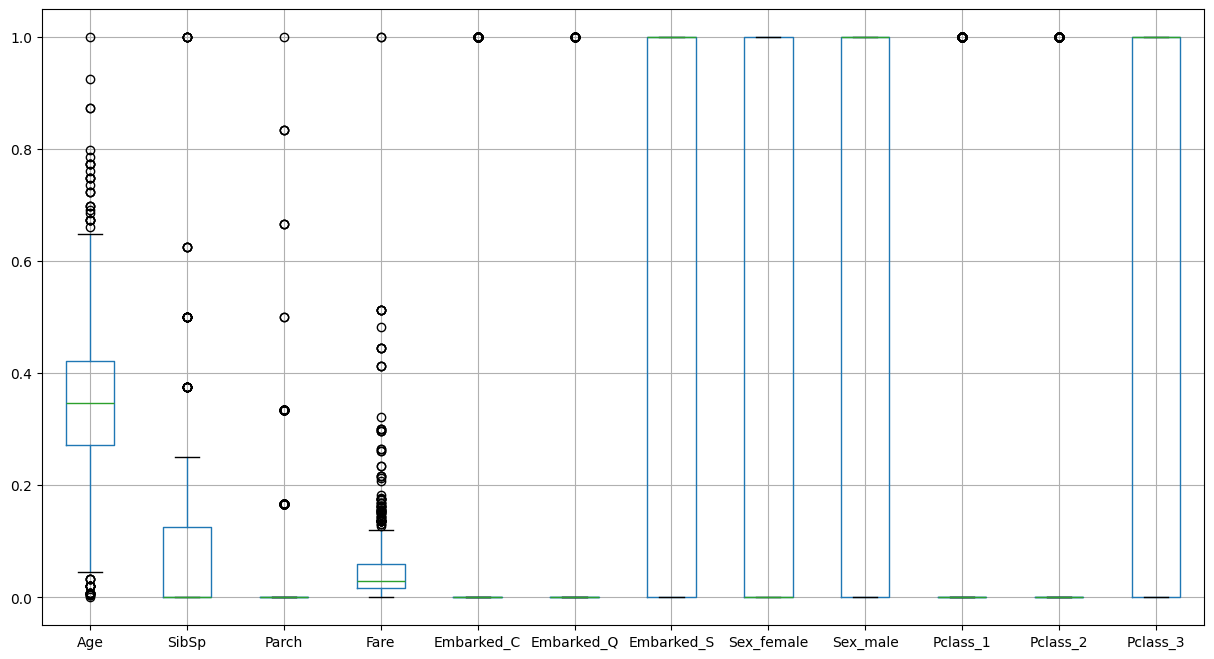

In [87]:
# plot the distributions of the features post scaling
X_train.boxplot(figsize=(15, 8))

In [96]:
# apply winsorization to features separately to address outliers
for column in X_train:
    X_train[column] = mstats.winsorize(X_train[column], limits=(0.10, 0.10))
for column in X_dev:
    X_dev[column] = mstats.winsorize(X_dev[column], limits=(0.10, 0.10))
for column in X_test:
    X_test[column] = mstats.winsorize(X_test[column], limits=(0.10, 0.10))

<Axes: >

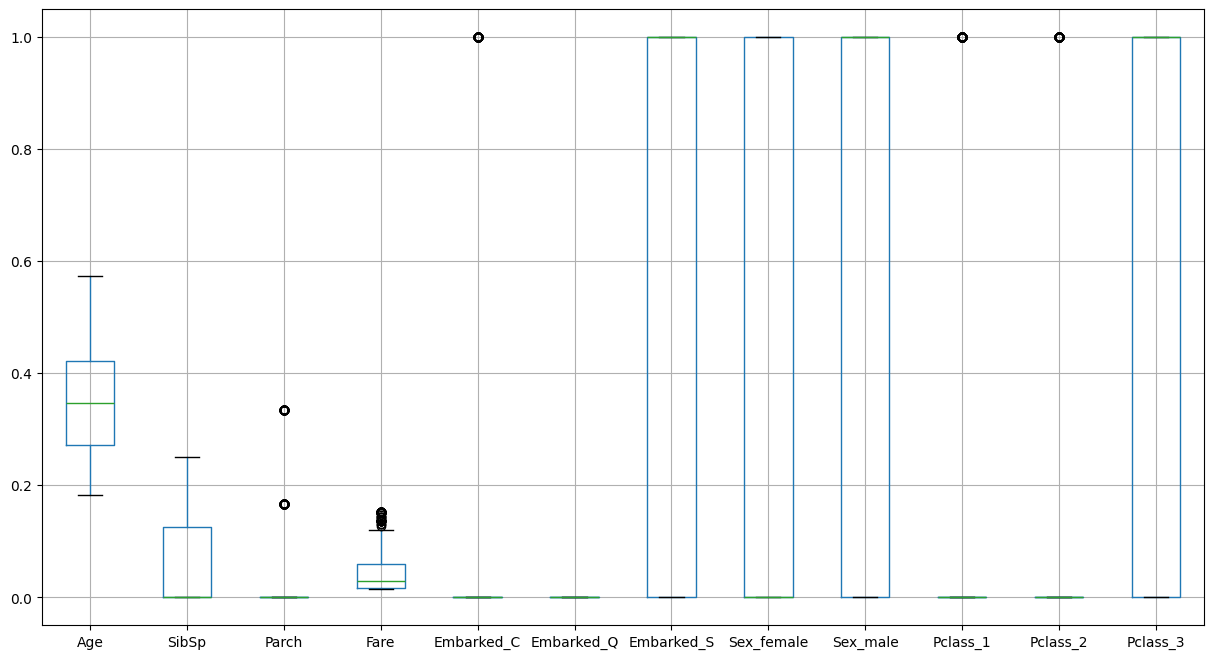

In [97]:
# plot the distributions of the features post winsorization
X_train.boxplot(figsize=(15, 8))

## Build and train a Decision Tree classifier

In [158]:
# instantiate and fit a vanilla decision tree classifier with no parameter 
random_seed = 42
dt_clf = DecisionTreeClassifier(random_state=random_seed)
dt_clf.fit(X_train, y_train)

#predict the response for train, dev and test datasets
y_train_pred = dt_clf.predict(X_train)
y_dev_pred = dt_clf.predict(X_dev)
y_test_pred = dt_clf.predict(X_test)

train_accuracy = dt_clf.score(X_train, y_train)
dev_accuracy = dt_clf.score(X_dev, y_dev)
test_accuracy = dt_clf.score(X_test, y_test)

# Model Accuracy 
print(f"Train accuracy: {train_accuracy}")
print(f"Development accuracy: {dev_accuracy}")
print(f"Test accuracy: {test_accuracy}")
print("At depth:", dt_clf.tree_.max_depth)

Train accuracy: 0.984182776801406
Development accuracy: 0.7692307692307693
Test accuracy: 0.7597765363128491
At depth: 23


The model correctly predicted the survival outcome for approximately 98.42%, 76.92% and 75.98% of the passengers on the train, development and test sets respectively with a maximum depth of 23.

- The model achieves very high accuracy on the training set (98.42%), which suggests that it has learned the training data well.
  
- There's a notable drop in accuracy on the development and test sets (76.92% and 75.98% respectively), indicating potential overfitting. Overfitting occurs when a model learns to perform well on the training data but fails to generalize well to unseen data.
  
- The high depth of 23 might contribute to overfitting. A deeper tree can capture more complex patterns in the training data but may not generalize well to unseen data.

Text(0.5, 1.0, 'Test Confusion Matrix')

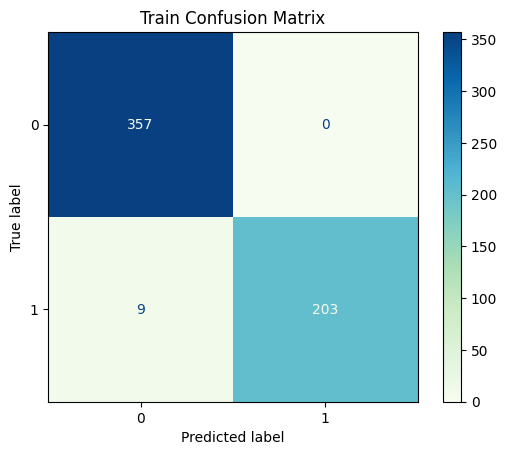

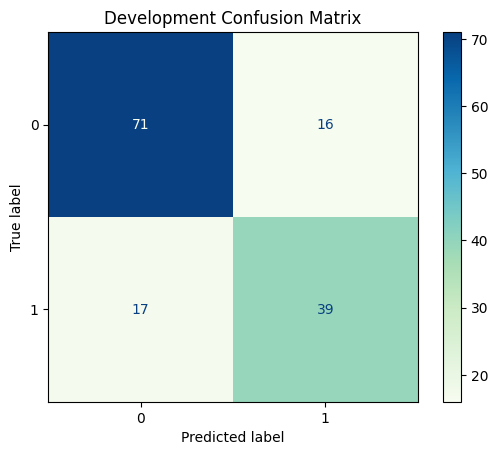

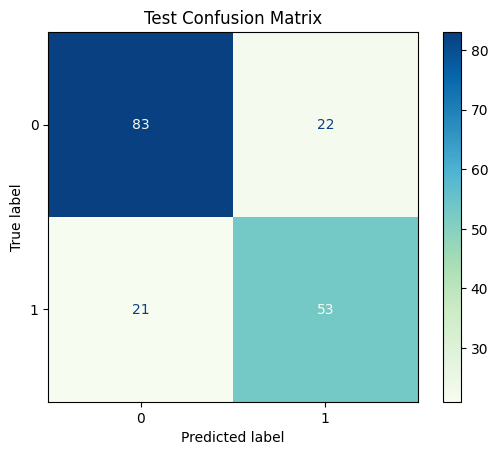

In [157]:
# Confusion Matrix of the classifier on the train, dev and test sets
cm = confusion_matrix(y_train, y_train_pred, labels=dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_clf.classes_)
disp.plot(cmap='GnBu')
plt.title('Train Confusion Matrix')

cm = confusion_matrix(y_dev, y_dev_pred, labels=dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_clf.classes_)
disp.plot(cmap='GnBu')
plt.title('Development Confusion Matrix')

cm = confusion_matrix(y_test, y_test_pred, labels=dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt_clf.classes_)
disp.plot(cmap='GnBu')
plt.title('Test Confusion Matrix')

the confusion matrix on the train set indicates:

- The model correctly predicted **357** instances where passengers did not survive (True Negatives).
- The model correctly predicted **203** instances where passengers survived (True Positives).
- The model incorrectly predicted **9** instances as not surviving when they actually did (False Negatives).
- There were no instances incorrectly predicted as surviving when they did not (False Positives).

the confusion matrix on the development set indicates:

- The model correctly predicted **71** instances where passengers did not survive (True Negatives).
- The model correctly predicted **39** instances where passengers survived (True Positives).
- The model incorrectly predicted **16** instances as not surviving when they actually did (False Negatives).
- The model incorrectly predicted **17** instances as surviving when they did not (False Positives).

the confusion matrix on the test set indicates:
- The model correctly predicted **83** instances where passengers did not survive (True Negatives).
- The model correctly predicted **53** instances where passengers survived (True Positives).
- The model incorrectly predicted **22** instances as not surviving when they actually did (False Negatives).
- The model incorrectly predicted **21** instances as surviving when they did not (False Positives).  

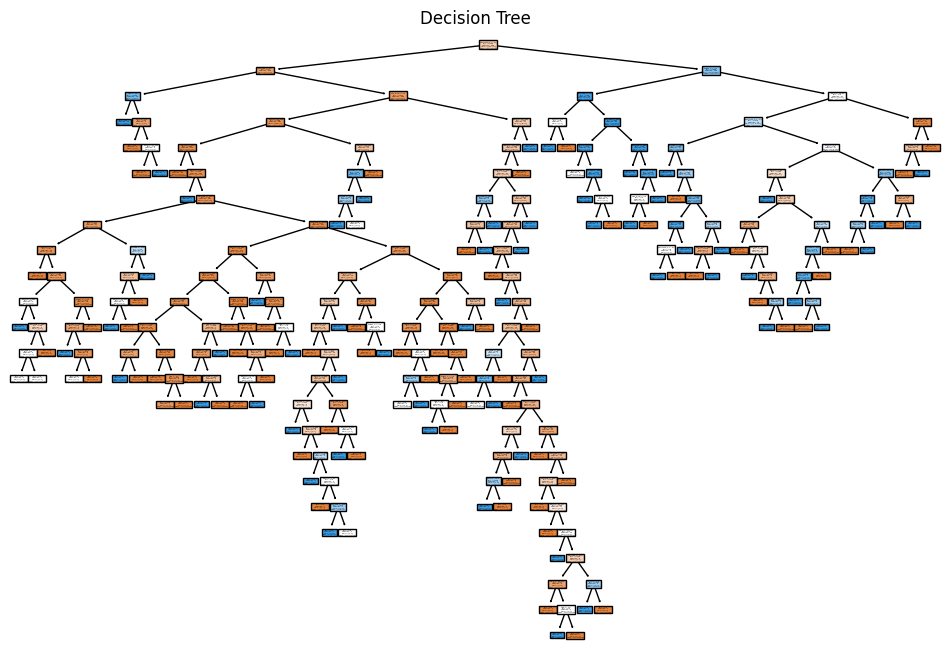

In [159]:
# plot the basic decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_clf, feature_names=titanic_df.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title('Decision Tree')
plt.show()

### **Decision Tree with pre-defined max-depth**

Tree with Max depth of: 2
Train accuracy: 0.7996485061511424
Development accuracy: 0.8181818181818182
Test accuracy: 0.7653631284916201


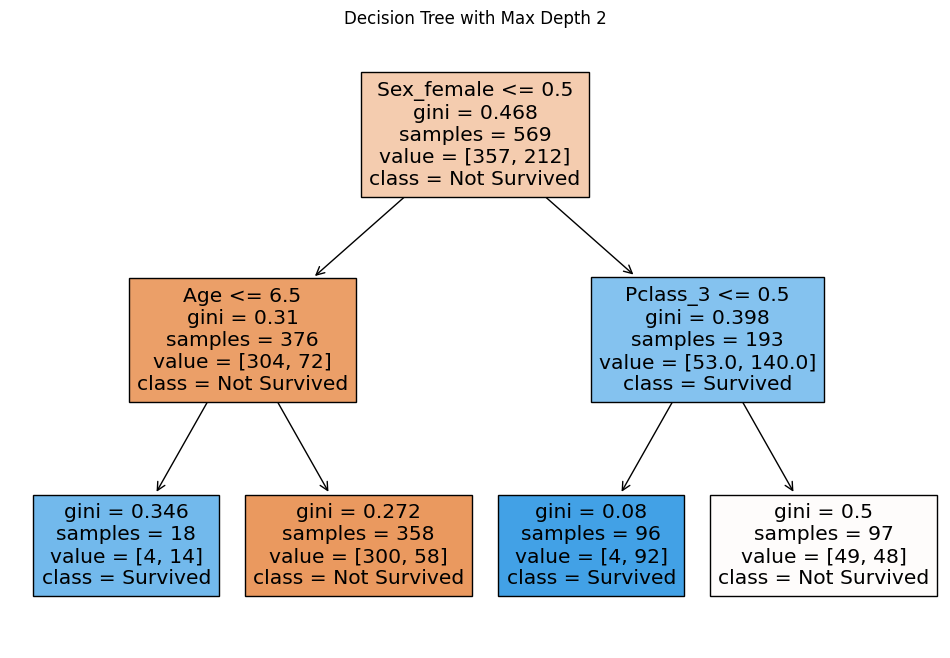

Tree with Max depth of: 3
Train accuracy: 0.8330404217926186
Development accuracy: 0.8321678321678322
Test accuracy: 0.7988826815642458


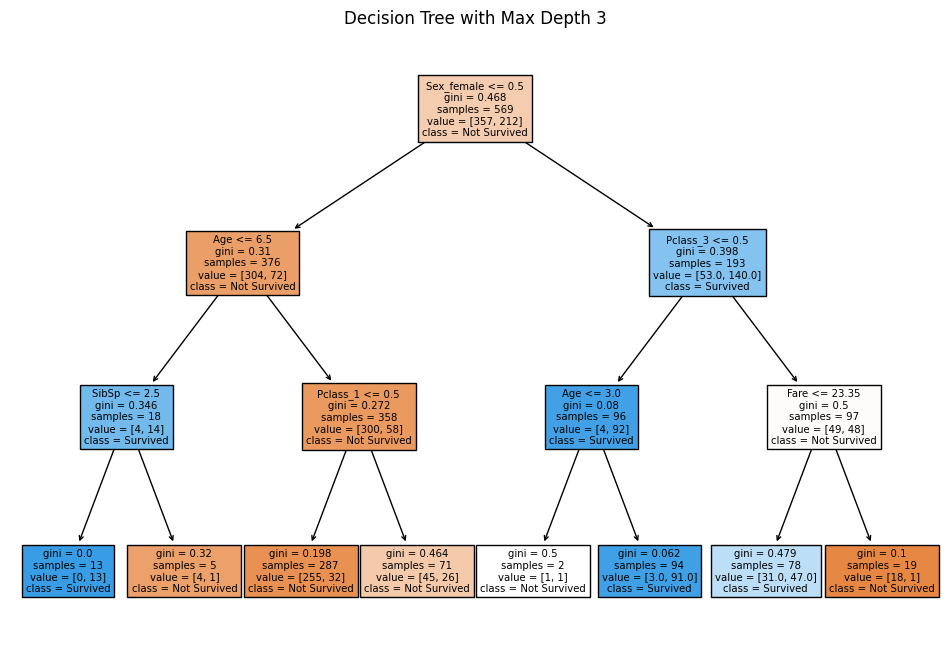

Tree with Max depth of: 4
Train accuracy: 0.8383128295254832
Development accuracy: 0.8391608391608392
Test accuracy: 0.7988826815642458


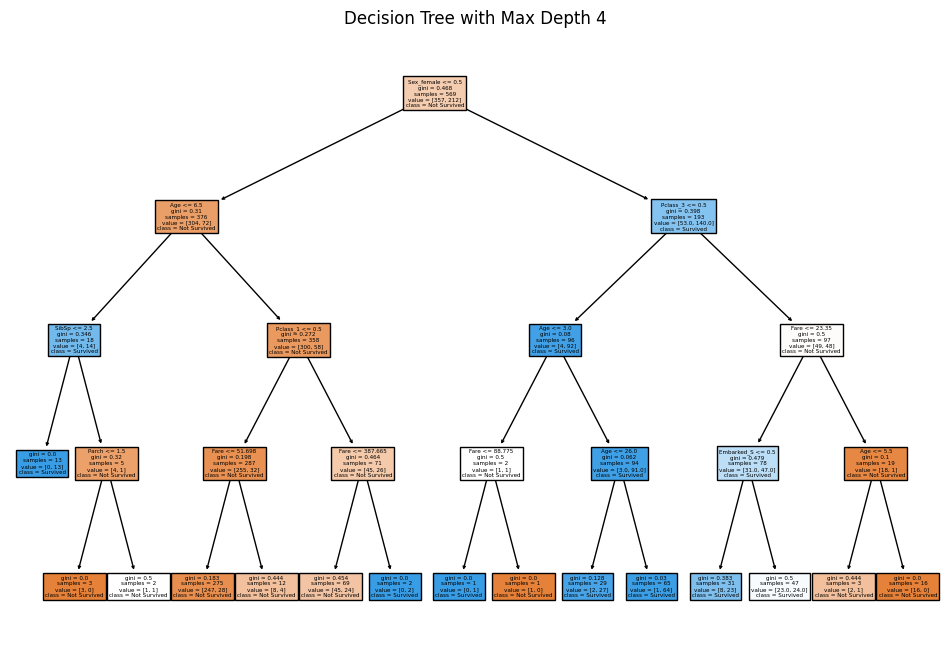

Tree with Max depth of: 5
Train accuracy: 0.8558875219683656
Development accuracy: 0.8181818181818182
Test accuracy: 0.8044692737430168


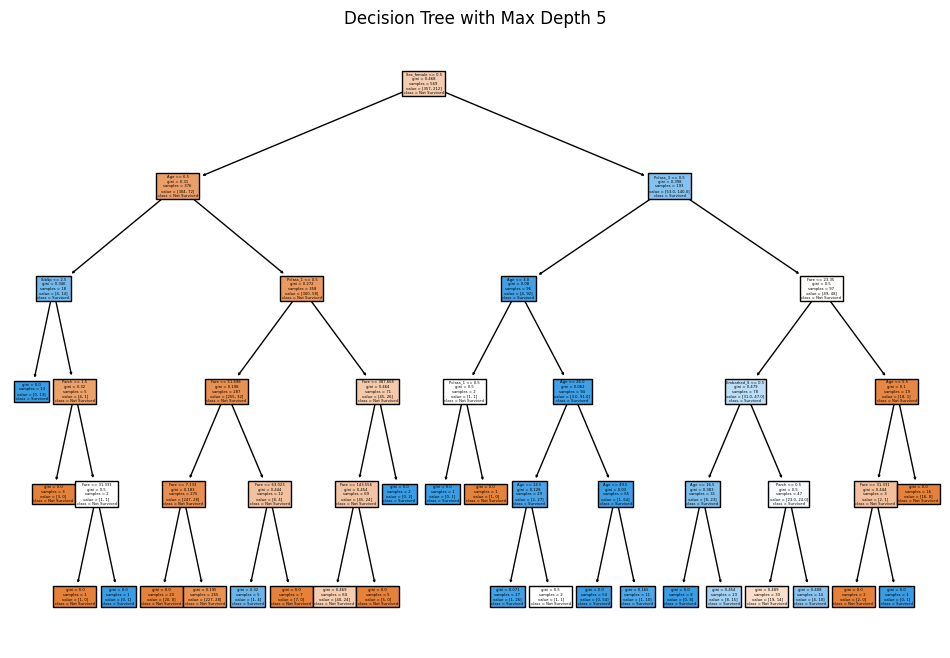

Tree with Max depth of: 6
Train accuracy: 0.8787346221441125
Development accuracy: 0.7762237762237763
Test accuracy: 0.7877094972067039


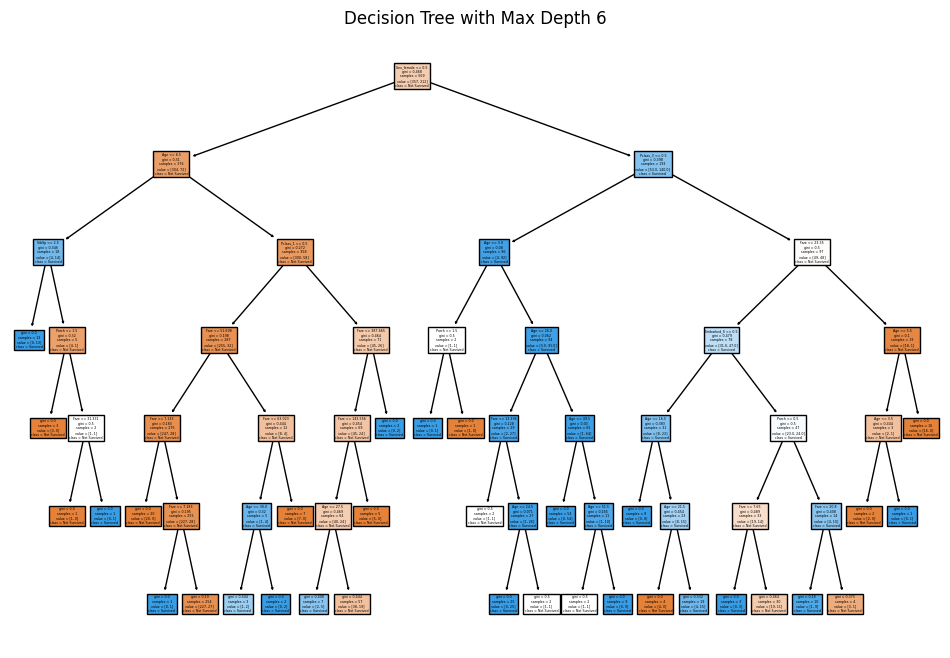

Tree with Max depth of: 7
Train accuracy: 0.8927943760984183
Development accuracy: 0.8251748251748252
Test accuracy: 0.770949720670391


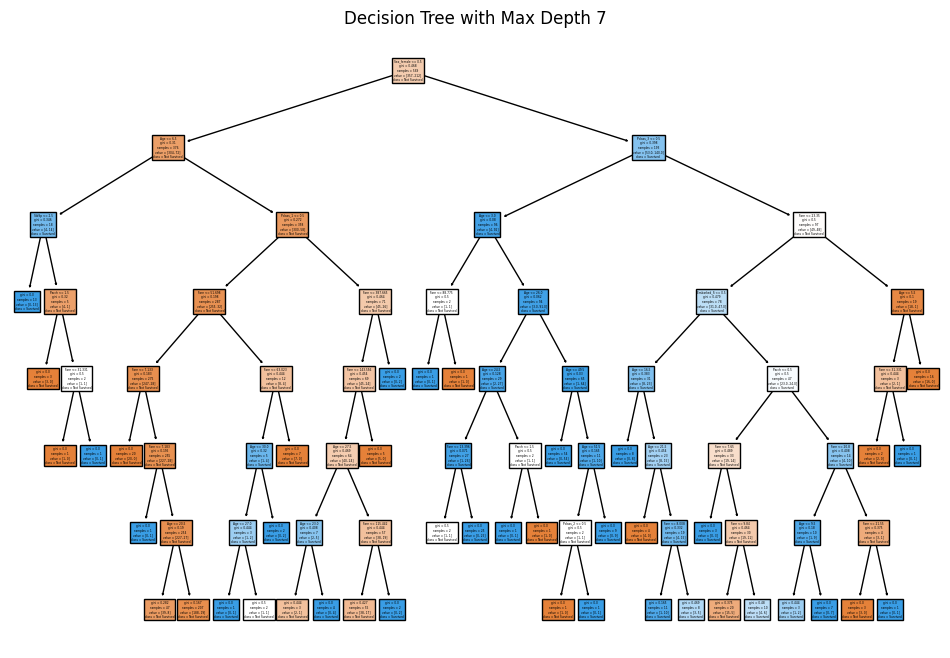

Tree with Max depth of: 8
Train accuracy: 0.9068541300527241
Development accuracy: 0.8111888111888111
Test accuracy: 0.7877094972067039


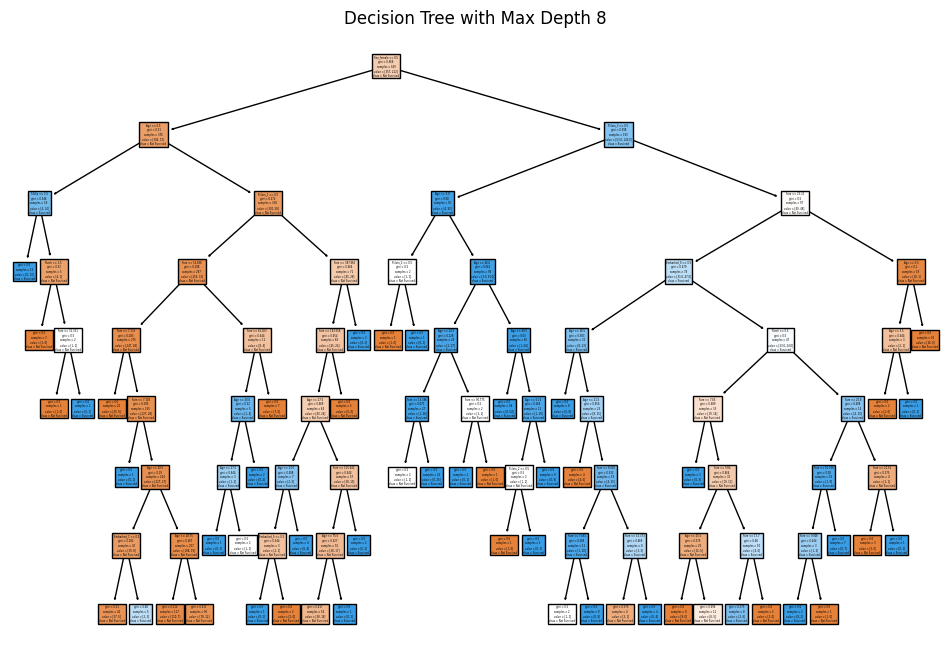

Tree with Max depth of: 9
Train accuracy: 0.9191564147627417
Development accuracy: 0.8041958041958042
Test accuracy: 0.7877094972067039


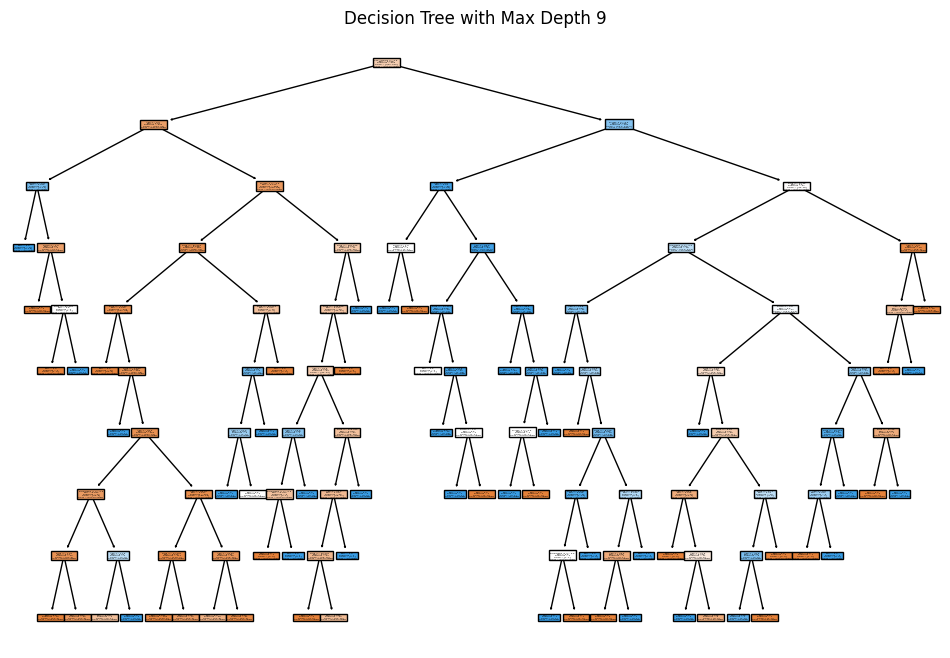

Tree with Max depth of: 10
Train accuracy: 0.9261862917398945
Development accuracy: 0.8041958041958042
Test accuracy: 0.7932960893854749


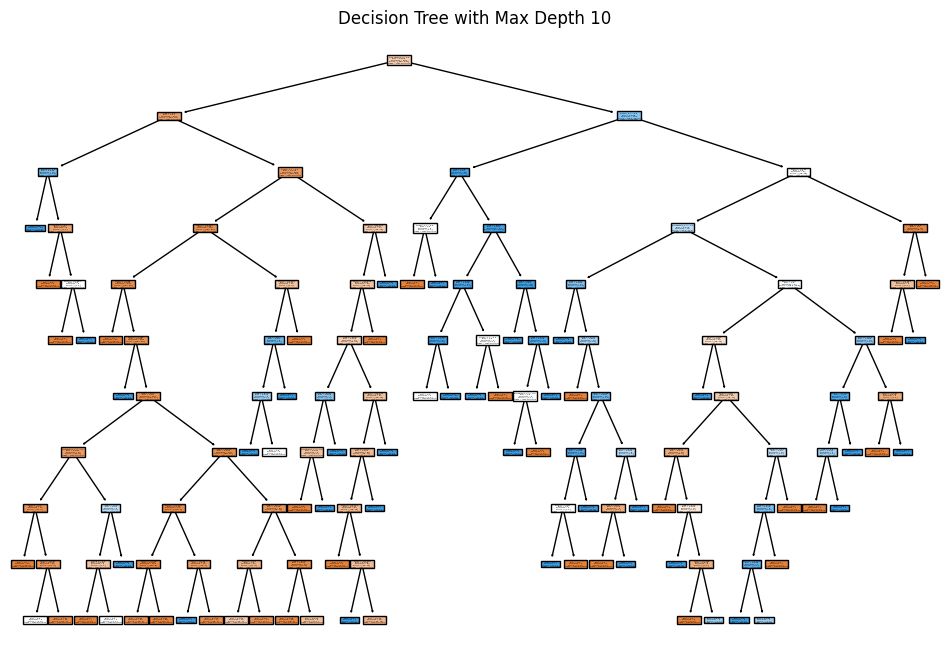

In [123]:
# initialize lists to store accuracies
train_accuracies = []
dev_accuracies = []
test_accuracies = []
trees = []

# loop through different max_depth values
for depth in range(2, 11):
    # Train a decision tree
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    # store the tree
    trees.append(tree)
    
    # compute accuracies
    train_accuracy = tree.score(X_train, y_train)
    dev_accuracy = tree.score(X_dev, y_dev)
    test_accuracy = tree.score(X_test, y_test)
    
    # store and print accuracies
    train_accuracies.append(train_accuracy)
    dev_accuracies.append(dev_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Tree with Max depth of: {depth}")
    print(f"Train accuracy: {train_accuracy}")
    print(f"Development accuracy: {dev_accuracy}")
    print(f"Test accuracy: {test_accuracy}")

    # plot the decision tree
    plt.figure(figsize=(12, 8))
    plot_tree(tree, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'], filled=True)
    plt.title(f'Decision Tree with Max Depth {depth}')
    plt.show()

### **Plotting the accuracies**

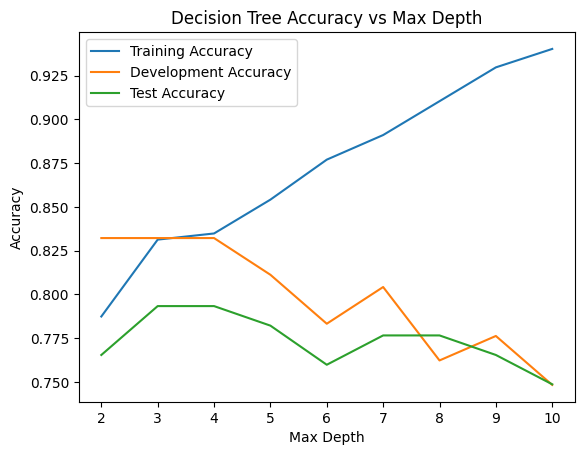

In [107]:
plt.plot(max_depths, train_accuracies, label='Training Accuracy')
plt.plot(max_depths, dev_accuracies, label='Development Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.show()

As depicted in the graph above, the classifier's accuracy on the test data declines as the max-depth exceeds **4**. With increasing depth, the model's accuracy on both development and test sets diminishes. The accuracy on the development data peaks at **83.92%** with a depth of **4**. Similarly, the accuracy on the test data reaches its maximum of **80.45%** at a depth of **5**.

### **Accuracy of the final model on the test data**

In [163]:
# final model with the best depth
best_depth_index = test_accuracies.index(max(test_accuracies))
best_tree = trees[best_depth_index]
best_depth = best_tree.get_depth()
test_accuracy = round(best_tree.score(X_test, y_test), 4)
print(f"Accuracy of the final model on the test data is '{test_accuracy}' at the depth of '{best_depth}'")

Accuracy of the final model on the test data is '0.8045' at the depth of '5'
